## **RADI608: Data Mining and Machine Learning**

### Assignment: Support Vector Machines 
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

## Question 1
#### Given the data <code>X = [[-2, 1], [-2, -1], [-1, -1.5], [1, 1], [1.5, -0.5],[2, -2]]</code> and <code>y = [1, -1, -1, 1, 1, -1]</code>, find the vector **$w$** and bias **$b$** if the support vectors are <code>(1.5, -0.5)</code> and <code>(2,-2)</code>.

**SOLUTION**: Suppose $\alpha_i$ such that $i = [1, 2]$ is the Lagrangian multiplier that denotes the weights of all the training points as support vectors. In this problem, we assume $\mathbf{X}, \mathbf{y}$ is a linearly separable dataset and assume that $s_1 = (1.5, -0.5)$ and $s_2 = (2, -2)$ are the support vectors of the linearly separable dataset. 

\begin{equation}
\begin{aligned}
    \alpha_1 \phi(s_1) \cdot \phi(s_1) + \alpha_2 \phi(s_2) \cdot \phi(s_1) &=  1 \\
    \alpha_1 \phi(s_1) \cdot \phi(s_2) + \alpha_2 \phi(s_2) \cdot \phi(s_2) &= -1 \\

\end{aligned}
\end{equation}

Since the data is linearly separable, we can use a linear SVM (that is, one whose mapping function $\phi(\cdot) = I$ is the identity function). Hence, we can reduce Equation $1$ into

\begin{equation*}
\begin{aligned}
    \alpha_1 \tilde{s_1} \cdot \tilde{s_1} + \alpha_2 \tilde{s_2} \cdot \tilde{s_1} &=   1 \\
    \alpha_1 \tilde{s_1} \cdot \tilde{s_2} + \alpha_2 \tilde{s_2} \cdot \tilde{s_2} &=  -1 \\
\end{aligned}
\end{equation*}

We will use vectors augmented with a 1 as a bias input. Hence, our support vectors are $\tilde{s_1} = [1.5, 0.5, 1]$ and $\tilde{s_2} = [2, -2, 1]$. Our task is to find values for the $\alpha_i$ such that

\begin{equation*}
\begin{aligned}
    \alpha_1  
    \begin{bmatrix}
     1.5  \\
    -0.5  \\
     1.0 \\ 
    \end{bmatrix}
    \cdot 
    \begin{bmatrix}
     1.5  \\
    -0.5  \\
     1.0 \\ 
    \end{bmatrix} 
    + \alpha_2 
    \begin{bmatrix}
    2.0  \\
    -2  \\
    1.0 \\ 
    \end{bmatrix} 
    \cdot 
    \begin{bmatrix}
     1.5  \\
    -0.5  \\
     1.0 \\ 
    \end{bmatrix} &=   1 \\


    \alpha_1 
    \begin{bmatrix}
     1.5  \\
    -0.5  \\
     1.0 \\ 
    \end{bmatrix} 
    \cdot 
    \begin{bmatrix}
    2.0  \\
    -2  \\
    1.0 \\ 
    \end{bmatrix}  
    + 
    \alpha_2 
    \begin{bmatrix}
    2.0  \\
    -2  \\
    1.0 \\ 
    \end{bmatrix}  
    \cdot 
    \begin{bmatrix}
    2.0  \\
    -2  \\
    1.0 \\ 
    \end{bmatrix} 
    &=  -1 \\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
    \alpha_1 (1.5 * 1.5 + 0.5 * 0.5 + 1.0  * 1.0) + 
    \alpha_2 (2.0 * 1.5 + (-2.0 * 0.5) + 1.0 * 1.0) 
    &=   1 \\

    \alpha_1 (1.5 * 2.0 + (0.5 * -2.0)  + 1.0 * 1.0) +
    \alpha_2 (2.0 * 2.0 + (-2.0 * -2.0) + 1.0 * 1.0)
    &=  -1 \\
\end{aligned}
\end{equation*}

\begin{equation*}
\begin{aligned}
    3.5 \alpha_1 + 5 \alpha_2  &=   1 \\
    5   \alpha_1 + 9 \alpha_2  &=  -1 \\
\end{aligned}
\end{equation*} 

Using Gaussian elimination, the $\alpha_i$ are given by $\alpha_1 = 2.153846$ and $\alpha_2 = -1.307692$. Now, we can look at how these $\alpha_i$ values relate to the discriminating hyperplane.

\begin{equation*}
\begin{aligned}
    \tilde{w} &= \sum_{i}^{2}\alpha_i \tilde{s}_i \\
    \tilde{w} &= \alpha_1 \tilde{s}_1 + \alpha_2 \tilde{s}_2 \\
    \tilde{w} &= (2.153846) 
    \begin{bmatrix}
     1.5  \\
    -0.5  \\
     1.0 \\ 
    \end{bmatrix}
    +
    (-1.307692) 
    \begin{bmatrix}
     2.0  \\
    -2.0  \\
     1.0 \\ 
    \end{bmatrix} \\

    \tilde{w} &=  
    \begin{bmatrix}
     3.230769  \\
    -1.076923  \\
     2.153846 \\ 
    \end{bmatrix}
    + 
    \begin{bmatrix}
    -2.615384  \\
     2.615384  \\
    -1.307692 \\ 
    \end{bmatrix} \\
    
    \tilde{w} &= 
    \begin{bmatrix}
     0.615385  \\
     1.538461  \\
     0.846615 \\ 
    \end{bmatrix}
\end{aligned}
\end{equation*}



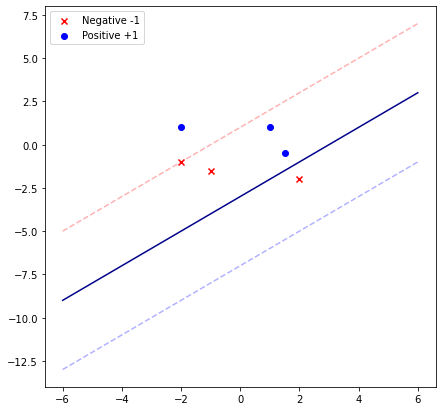

In [183]:
x_pos = np.array([[-2,  1], [1, 1], [1.5, -0.5]])
y_pos = np.array([1, 1, 1])

x_neg = np.array([[-2, -1], [-1, -1.5],[2, -2]])
y_neg = np.array([-1, -1, -1])

x1 = np.linspace(-6, 6)
x = np.vstack((np.linspace(-10,10),np.linspace(-10,10)))

X = np.vstack((x_pos, x_neg))
y = np.concatenate((y_pos,y_neg))

w = np.array([0.615385, 1.538461]).reshape(-1,1)
b = 0.846615

fig = plt.figure(figsize = (7, 7))
plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b', label = 'Positive +1')
plt.plot(x1, x1  - 3, color = 'darkblue')
plt.plot(x1, x1  - 7, linestyle = '--', alpha = .3, color = 'b')
plt.plot(x1, x1  + 1, linestyle = '--', alpha = .3, color = 'r')
plt.legend()

## Question 2 - <code>SVM-2F</code>
#### Create a SVM-model and plot a 2D-SVM classification by using Python and colon data set (use only two genes, T62947 and H64807), and find your best hyper-parameters for precision, recall, and accuracy. <code>(Training:Testing = 80:20)</code>

**SOLUTION**: First, we denote <code>SVM-2F</code> as the SVM model with only two features. In this section, we only used two features called <code>T62947</code> and <code>H64807</code>. Hence, the number of samples <code>m = 62</code> is greater than the number of features <code>n = 2</code>. The class distribution, however, is imbalanced with 22 patients having cancer while 40 patients having no cancer. Hence, it is important to perform resampling techniques (i.e., undersampling, oversampling, SMOTE). 

We verified the dataset in terms of their data types (i.e., <code>float</code> for $\mathbf{X}$ while <code>int</code> for $\mathbf{y}$) to ensure proper data modeling in SVM. No missing values were detected in the dataset. In addition, we normalize the given dataset through standardization by removing the mean and scaling to unit variance. We also split the data into 80:20 ratio between training and testing sets.

In [184]:
df_colon = pd.read_csv('../data/colon.csv')
XX = df_colon[['T62947', 'H64807']]
yy = df_colon['Class']

XX, yy = XX.to_numpy(), yy.to_numpy()
yy = yy.flatten()

smote = SMOTE()
X, y = smote.fit_resample(XX, yy)

random.seed(413)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

Let's try to visualize the class distribution with and without resampling (i.e., SMOTE method). Since the given class distribution of the dataset is imbalanced, we performed oversampling using Synthetic Minority Oversampling Technique (SMOTE) as presented above as <code>smote = SMOTE()</code>.

Text(0.5, 1.0, 'SMOTE Resampling')

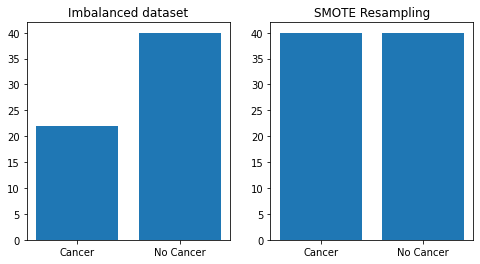

In [185]:
x = np.arange(2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))

ax1.bar(x, height = [len(yy[yy == 1]), len(yy[yy == -1])])
ax1.set_xticks(x, ['Cancer', 'No Cancer'])
ax1.set_title('Imbalanced dataset')

ax2.bar(x, height = [len(y[y == 1]), len(y[y == -1])])
ax2.set_xticks(x, ['Cancer', 'No Cancer'])
ax2.set_title('SMOTE Resampling')

We created a Python function called <code>plot_data</code> to visually create the scatter plot of the features between two classes. We labeled the two classes <code>i.e., (y = -1, y = 1)</code> as 'No Cancer' and 'Cancer' patients, respectively. Patients with no cancer are highlighted as color blue while patients without cancer are colored as red dots.

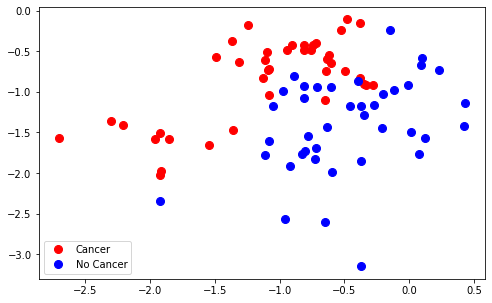

In [186]:
def plot_data(X, y):
    y = y.flatten()
    class1 = (y ==  1)
    class2 = (y == -1)
    plt.figure(figsize=(8, 5))    
    plt.plot(X[:,0][class1], X[:,1][class1], 'ro', markersize = 8, label = 'Cancer')
    plt.plot(X[:,0][class2], X[:,1][class2], 'bo', markersize = 8, label = 'No Cancer')
    plt.legend(loc = 'lower left')

plot_data(X, y)

We find the best hyper-parameters for <code>precision, recall, and accuracy</code>. Other performance evaluation, such as <code>AUC</code> and <code>F1-score</code>, were also tuned for simulation purposes. We then initialized the parameters on a given range and types for <code>kernel</code>, <code>gamma</code>, and <code>C</code>. A 5-fold cross-validation was also adopted here. We set <code>random.seed(413)</code> to initialize the random number generator. The <code>Accuracy</code> was evaluated as a refit method to refit an estimator using the best found parameters on the whole dataset.

In [187]:
tuned_parameters = [{'kernel': ['rbf'],     'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-7], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-7], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'],                                              'C': [0.001, 0.10, 0.1, 10, 20, 25, 50, 100, 1000]}]

scoring = {'Precision': 'precision', 'Recall': 'recall', 'Accuracy': 'accuracy', 
           'AUC': 'roc_auc', 'F1': 'f1_micro'}
    
random.seed(413)
clf = GridSearchCV(SVC(C = 1), param_grid = tuned_parameters, cv = 5,
                    scoring = scoring, refit = 'Accuracy',
                    return_train_score = True)
clf.fit(X_train, y_train)
results = clf.cv_results_

print(f'Best parameter set found on development set: {clf.best_params_}')

Best parameter set found on development set: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}


We created a Python function called <code>visualize_boundary</code> that plots the data and its decision boundary between the classes.

<Figure size 1080x720 with 0 Axes>

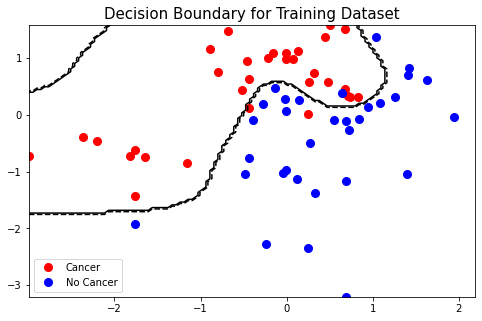

In [188]:
random.seed(413)
svclassifier = SVC(kernel = 'rbf', C = 25, gamma = 1)
svclassifier.fit(X_train, y_train)

def visualize_boundary(X, y, model, title):
    plt.figure(figsize = (15, 10))
    plot_data(X, y)
    X_21, X_22 = np.meshgrid(np.linspace(X[:,0].min(), X[:,1].max(), num = 100), 
                             np.linspace(X[:,1].min(), X[:,1].max(), num = 100))
    plt.contour(X_21, X_22, model.predict(np.array([X_21.ravel(),X_22.ravel()]).T).reshape(X_21.shape), 1, colors = 'k')
    plt.title(title, size = 15)
    plt.legend(loc = 'lower left')
    plt.show()

random.seed(413)
visualize_boundary(X_train, y_train, svclassifier, 
                            title = 'Decision Boundary for Training Dataset')

The code below calculates the predictions <code>y_pred</code> from the testing set. We then used <code>y_pred</code> to create the confusion matrix and classification report.

In [189]:
y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = ['Cancer', 'No Cancer']))

[[8 0]
 [0 8]]
              precision    recall  f1-score   support

      Cancer       1.00      1.00      1.00         8
   No Cancer       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



### Conclusion - <code>SVM-2F</code>:
The SVM model with two features, denoted as <code>SVM-2F</code> produced **perfect** results, as shown to its classification report. The results indicated that <code>SVM-2F</code> did not predict any misclassifications between the two classes since the number of false positive and false negative are zero.  

We evaluated <code>SVM-2F</code> in two scenarios - SVM model with and without SMOTE, through two performance metrics: <code>Accuracy</code> and <code>F1-score</code>, respectively. **While accuracy is best suited for balanced datasets and F1-score is applied for imbalanced datasets, regardless of the resampling methods, both evaluation metrics produced 100% accuracy and F1-score.** However, it is important to note that we need to use <code>F1-score</code> for imbalanced datasets because it can quantify the harmonic mean of both precision and recall for the minority class. Hence, <code>F1-score</code> should be used when class distribution is uneven.

## Question 3 - <code>SVM-AF</code>
#### Train a SVM-model by using colon-data set and tuning the hyper-parameters, and select the best model. <code>(Training:Testing = 80:20)</code> and give your comments.

**SOLUTION**: In this section, we used <code>m = 80</code> samples with <code>n = 2000</code> features. Hence, the number of samples is **lower** than the number of features. Since traditional machine learning models assume $m > n$, this challenge of high-dimensional spaces is referred to as the curse of dimensionality. In this section, we will solve Question 3 into two scenarios - using SVM with $m < n$ and SVM with feature selection methods.

In the code below, we initialized $\mathbf{X, y}$ and plotted it using the <code>plot_data</code> function we created earlier.

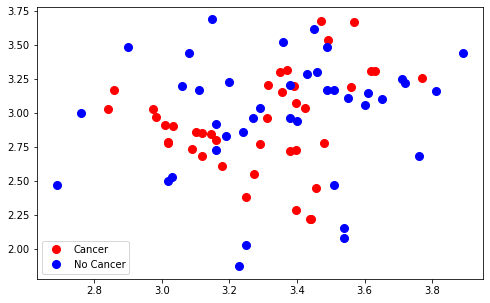

In [175]:
XX = df_colon.drop('Class', axis = 1)
yy = df_colon['Class']

X, y = smote.fit_resample(XX, yy)
X, y = X.to_numpy(), y.to_numpy()
y = y.flatten()

plot_data(X, y)

Similar to Question 2, we also find the best hyper-parameters for <code>precision, recall, accuracy, AUC, and F1-score</code>. We then initialized the parameters on a given range and types for <code>kernel</code>, <code>gamma</code>, and <code>C</code>. A 5-fold cross-validation was also adopted here. We set <code>random.seed(413)</code> to initialize the random number generator. The <code>F1-score</code> was evaluated as a refit method to refit an estimator using the best found parameters on the whole dataset. In addition, the <code>F1-score</code> as a refit method can help balance the metric across positive and negative samples.

In [176]:
random.seed(413)
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

tuned_parameters = [{'kernel': ['rbf'],     'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-7], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-7], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'],                                              'C': [0.001, 0.10, 0.1, 10, 20, 25, 50, 100, 1000]}]

scoring = {'Precision': 'precision', 'Recall': 'recall', 'Accuracy': 'accuracy', 
           'AUC': 'roc_auc', 'F1': 'f1_micro'}
    
random.seed(413)
clf = GridSearchCV(SVC(C = 10), param_grid = tuned_parameters, cv = 5,
                    scoring = scoring, refit = 'F1',
                    return_train_score = True)
clf.fit(X_train, y_train)
results = clf.cv_results_

print(f'Best parameters set found on development set: {clf.best_params_}')

Best parameters set found on development set: {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}


In [177]:
random.seed(413)
svclassifier = SVC(kernel = 'rbf', C = 10, gamma = 0.0001)
svclassifier.fit(X_train, y_train)

SVC(C=10, gamma=0.0001)

The code below calculates the predictions <code>y_pred</code> from the testing set. We then used <code>y_pred</code> to create the confusion matrix and classification report.

In [178]:
y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = ['Cancer', 'No Cancer']))

[[9 1]
 [0 6]]
              precision    recall  f1-score   support

          -1       1.00      0.90      0.95        10
           1       0.86      1.00      0.92         6

    accuracy                           0.94        16
   macro avg       0.93      0.95      0.94        16
weighted avg       0.95      0.94      0.94        16



### Conclusion:
The SVM model with all features in the dataset, denoted as <code>SVM-AF</code>, generally produced excellent results. However, its performance metrics are comparatively lower than <code>SVM-2F</code>, since <code>SVM-AF</code> uses a large number of features for each data point that exceed the number of data samples. This problem is known as the **curse of dimensionality** since the feature space will have many subregions with few samples that the SVM will lose predictive power given that it did not get to learn the behaviour of the data in many significant subregions. While <code>SVM-AF</code> underperforms due to its dimensions, we can rectify this problem by using a lower $C$ to regularize the dataset stronger since the training errors may increase in size, which can induce overfitting.